In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
data = pd.read_csv(r"C:\Users\fraud\Desktop\Quinill soft\retail_sales.csv")

# Display the first few rows and the column names
print(data.head())
print(data.columns)

          Date      Sales
0  1/1/15 0:00  54.048619
1  1/1/15 1:00  50.161596
2  1/1/15 2:00  55.954939
3  1/1/15 3:00  56.553261
4  1/1/15 4:00  60.487874
Index(['Date', 'Sales'], dtype='object')


In [3]:
# Assuming the date column is named 'Date'
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces from column names
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime, handling errors
data.set_index('Date', inplace=True)  # Set the datetime column as index

# Check the result
print(data.head())
print(data.info())

C:\Users\fraud\AppData\Local\Temp\ipykernel_10276\2062040115.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime, handling errors


                         Sales
Date                          
2015-01-01 00:00:00  54.048619
2015-01-01 01:00:00  50.161596
2015-01-01 02:00:00  55.954939
2015-01-01 03:00:00  56.553261
2015-01-01 04:00:00  60.487874
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52585 entries, 2015-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   52585 non-null  float64
dtypes: float64(1)
memory usage: 821.6 KB
None


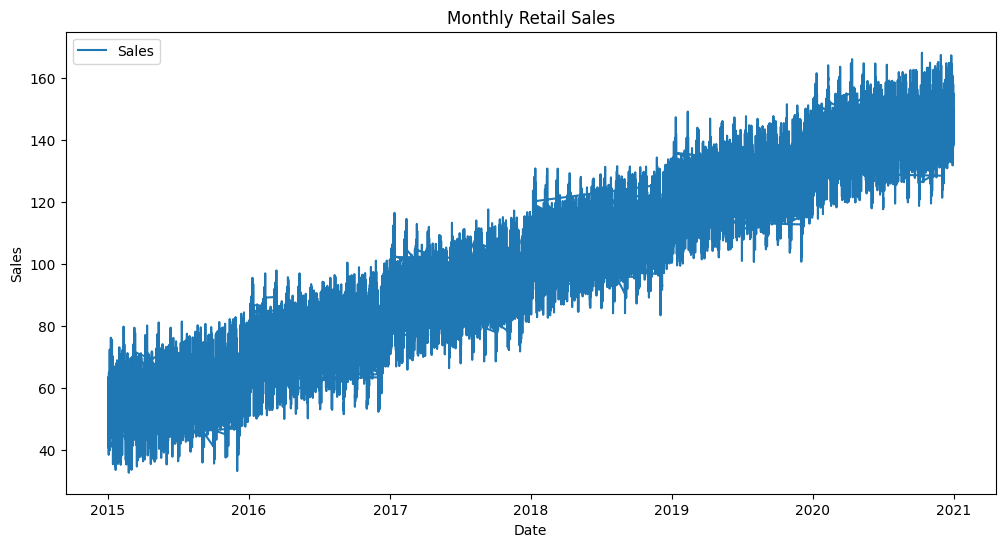

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 273s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 2/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 271s 6ms/step - loss: 5.7660e-04 - val_loss: 8.6886e-04
Epoch 3/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 279s 7ms/step - loss: 5.3541e-04 - val_loss: 0.0012
Epoch 4/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - loss: 5.0672e-04 - val_loss: 4.5953e-04
Epoch 5/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 277s 7ms/step - loss: 5.0517e-04 - val_loss: 0.0013
Epoch 6/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 278s 7ms/step - loss: 4.9979e-04 - val_loss: 0.0014
Epoch 7/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 263s 6ms/step - loss: 4.8736e-04 - val_loss: 0.0019
Epoch 8/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 257s 6ms/step - loss: 4.8558e-04 - val_loss: 7.4316e-04
Epoch 9/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 283s 7ms/step - loss: 4.8147e-04 - val_loss: 4.6616e-04
Epoch 10/20
42057/42057 ━━━━━━━━━━━━━━━━━━━━ 260s 6ms/step - loss: 4.7470e-04 - val_loss: 7.4091e-04
Epoch 11/20
42057/42057

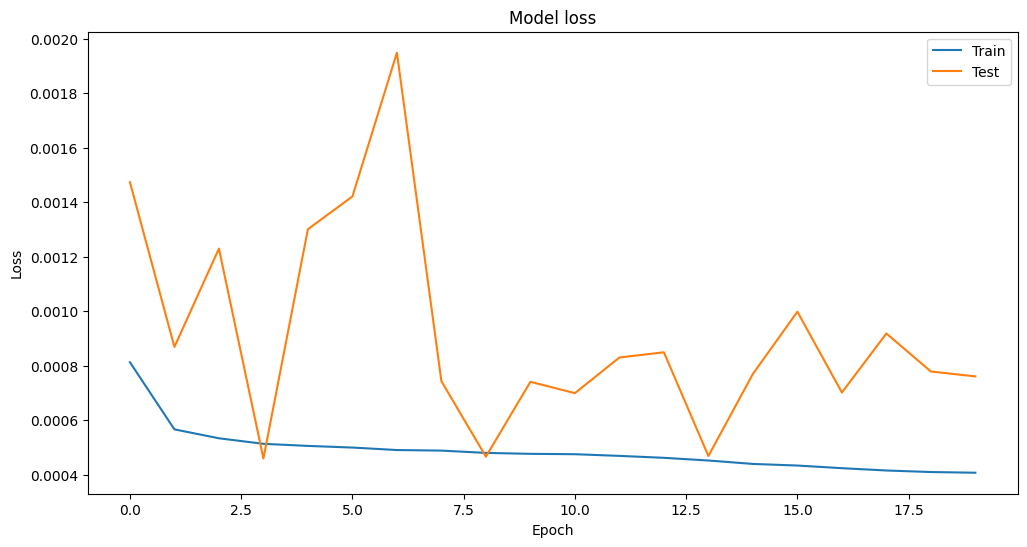

In [4]:
# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'], label='Sales')
plt.title('Monthly Retail Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Handle missing values
data = data.dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Sales'] = scaler.fit_transform(data['Sales'].values.reshape(-1,1))

# Prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_dataset(data.values, look_back)

# Split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, Y_train, batch_size=1, epochs=20, validation_data=(X_test, Y_test))

#save the model
model.save('retail_sales_forecasting_model.h5')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train Score: RMSE=2.69, MAE=2.15, R2=0.99
Test Score: RMSE=3.73, MAE=2.93, R2=0.86


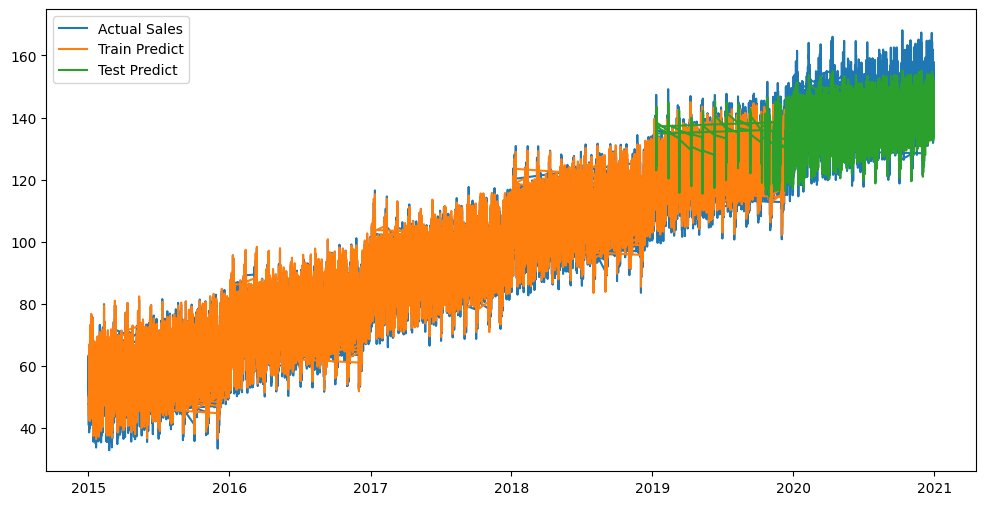

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\fraud\AppData\Local\Temp\ipykernel_10276\1078697490.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(data.index[-1], periods=future_steps + 1, freq='M')[1:]


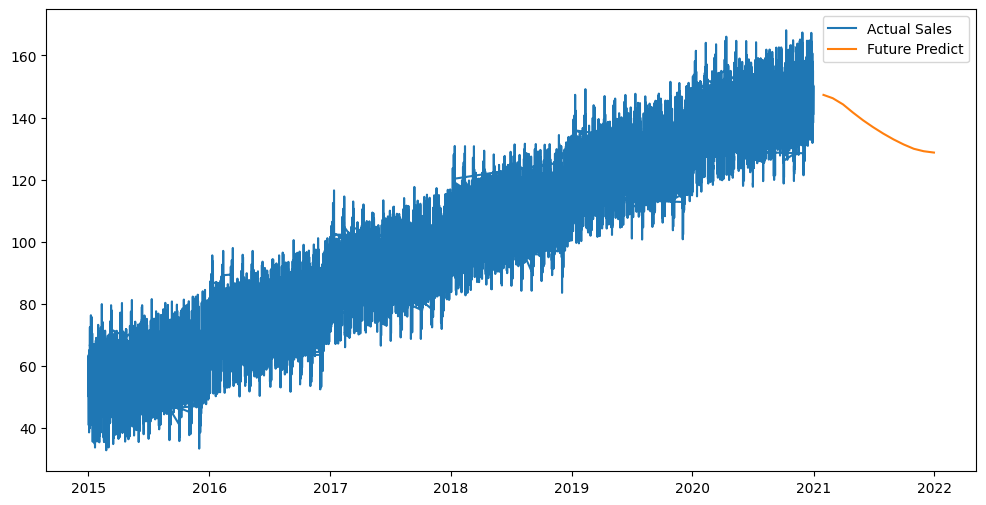

In [5]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate performance metrics
train_score_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
train_score_mae = mean_absolute_error(Y_train, train_predict)
test_score_mae = mean_absolute_error(Y_test, test_predict)
train_score_r2 = r2_score(Y_train, train_predict)
test_score_r2 = r2_score(Y_test, test_predict)

print(f'Train Score: RMSE={train_score_rmse:.2f}, MAE={train_score_mae:.2f}, R2={train_score_r2:.2f}')
print(f'Test Score: RMSE={test_score_rmse:.2f}, MAE={test_score_mae:.2f}, R2={test_score_r2:.2f}')

# Plot the predictions
plt.figure(figsize=(12, 6))

# Plot actual sales
actual_sales = scaler.inverse_transform(data['Sales'].values.reshape(-1, 1))
plt.plot(data.index, actual_sales, label='Actual Sales')

# Plot training predictions
train_plot = np.empty_like(data['Sales'])
train_plot[:] = np.nan
train_plot[look_back:len(train_predict) + look_back] = train_predict[:, 0]
plt.plot(data.index, train_plot, label='Train Predict')

# Plot testing predictions
test_plot = np.empty_like(data['Sales'])
test_plot[:] = np.nan
test_start_idx = len(train_predict) + (look_back * 2) + 1
test_end_idx = test_start_idx + len(test_predict)

if test_end_idx <= len(test_plot):
    test_plot[test_start_idx:test_end_idx] = test_predict[:, 0]
else:
    test_plot[test_start_idx:len(test_plot)] = test_predict[:len(test_plot) - test_start_idx, 0]

plt.plot(data.index, test_plot, label='Test Predict')

plt.legend()
plt.show()

# Forecast future sales
future_steps = 12
last_values = data[-look_back:].values
future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_values.reshape(1, look_back, 1))
    future_predictions.append(prediction[0, 0])
    last_values = np.append(last_values[1:], prediction[0, 0]).reshape(-1, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future predictions
future_dates = pd.date_range(data.index[-1], periods=future_steps + 1, freq='M')[1:]
plt.figure(figsize=(12, 6))
plt.plot(data.index, actual_sales, label='Actual Sales')
plt.plot(future_dates, future_predictions, label='Future Predict')
plt.legend()
plt.show()
